## Training Autoencoder with ignition events

**Status:** PUBLIC Distribution <br>
**File Name:** 02_Autoencoder_training_ignition_events.ipynb

**Author:** Jaume Manero / Darshana Upadhyay / Richard Purcell<br> 
**Date created:** 2023/06/19<br>
**Last modified:** 2023/06/19<br>
**Description:** Autoencoders for Forest Fire prediction

We train an autoencoder with a file with Ignition events. This is the first notebook. In this notebook we train the autoencoder to recognize ignition events. There is a map visualization of ignition events in BC

This version uses StandardScaling
We perform a feature importance analysis and qualify accuracy using a RandomForest Regressor and classifier

This notebook generates a file with 3 classes of events. Ignition, near-ignition and non-igntion <br>
0: non-ignition <br>
1: near-ignition <br>
2: ignition <br>


In [17]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Lambda, Input, Dense, Dropout
from tensorflow.keras.losses import mse, binary_crossentropy, kl_divergence
from tensorflow.keras.optimizers.legacy import SGD,Adam,RMSprop
from tensorflow.keras import backend as K
from tensorflow import keras
from sklearn.preprocessing import normalize
from keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [18]:
# Hyperparameters



In [3]:
path_ignition = './Data/ignition_rows.csv'
path_non_ignition = './Data/non_ignition_rows.csv'
ignition_df = pd.read_csv(path_ignition)  
non_ignition_df = pd.read_csv(path_non_ignition, nrows=1000000)  
ignition_df.columns

Index(['date', 'lon', 'lat', 'u10', 'v10', 'd2m', 't2m', 'e', 'cvh', 'cvl',
       'skt', 'stl1', 'stl2', 'stl3', 'stl4', 'slt', 'sp', 'tp', 'swvl1',
       'swvl2', 'swvl3', 'swvl4', 'month', 'day', 'hour', 'ignition'],
      dtype='object')

In [4]:
non_ignition_df.columns

Index(['date', 'lon', 'lat', 'u10', 'v10', 'd2m', 't2m', 'e', 'cvh', 'cvl',
       'skt', 'stl1', 'stl2', 'stl3', 'stl4', 'slt', 'sp', 'tp', 'swvl1',
       'swvl2', 'swvl3', 'swvl4', 'month', 'day', 'hour', 'ignition'],
      dtype='object')

In [5]:
ignition_df.drop(['lon', 'lat', 'date', 'ignition'], axis=1, inplace=True)
non_ignition_df.drop(['lon', 'lat', 'date', 'ignition'], axis=1, inplace=True)

In [6]:
# we create a numpy array with the features of every row
ignition_np = ignition_df.to_numpy()
print('ignition shape',ignition_np.shape)
non_ignition_np = non_ignition_df.to_numpy()
print('non_ignition shape',non_ignition_np.shape)

ignition shape (51918, 22)
non_ignition shape (1000000, 22)


In [7]:
ignition_df = ignition_df.replace([np.inf, -np.inf], 0)
scaler = MinMaxScaler()
scaler = StandardScaler()
#scaler = PowerTransformer()
ignition_scaled = scaler.fit_transform(ignition_df)
ignition_scaled.shape

(51918, 22)

In [8]:
non_ignition_df = non_ignition_df.replace([np.inf, -np.inf], 0)
scaler = MinMaxScaler()
scaler = StandardScaler()
#scaler = PowerTransformer()
non_ignition_scaled = scaler.fit_transform(non_ignition_df)
non_ignition_scaled.shape

(1000000, 22)

In [9]:
# generate train set
# training set will consist of ignition dataset

len_ignition = len(ignition_scaled)
len_ignition_train = int(0.80 * len_ignition)
X_train = ignition_scaled[:len_ignition_train]
X_train.shape

(41534, 22)

In [10]:
# generate non-ignition set
# test will be only non-ignition data (much larger)

len_non_ignition = len(non_ignition_scaled)
X_test = non_ignition_scaled
X_test.shape

(1000000, 22)

In [11]:
#remove Nans and convert them to 0
print(np.count_nonzero(np.isnan(X_train)))
X_train = np.nan_to_num(X_train)

1653


In [12]:
#remove Nans and convert them to 0
print(np.count_nonzero(np.isnan(X_test)))
X_test = np.nan_to_num(X_test)
# y_test.shape

1988597


In [13]:
def get_error_term(v1, v2, _rmse=True):
    if _rmse:
        return np.sqrt(np.mean((v1 - v2) ** 2, axis=1))
    #return MAE
    return np.mean(np.abs(v1 - v2), axis=1)

In [19]:
input_dim = X_train.shape[1]
encoding_dim = X_train.shape[1]
dr=0.02

print(input_dim)
latent_space = 4

dr = 0.15
input_ANN = Input(shape=(input_dim, ))
encoder = Dense(64, activation='relu')(input_ANN)
encoder = Dropout(rate=dr)(encoder)
encoder = Dense(32, activation='relu')(encoder)
encoder = Dropout(rate=dr)(encoder)
encoder = Dense(16, activation='relu')(encoder)

decoder = Dense(32, activation='relu')(encoder)
decoder = Dropout(rate=dr)(decoder)
decoder = Dense(64, activation='relu')(decoder)
decoder = Dropout(rate=dr)(decoder)
out_layer = Dense(encoding_dim, activation = 'sigmoid')(decoder)
autoencoder = keras.Model(inputs=input_ANN, outputs=out_layer)

22


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 22)]              0         
                                                                 
 dense_2 (Dense)             (None, 64)                1472      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                                 
 dense_5 (Dense)             (None, 32)                544   

41534/41534 [==============================] - 1s 34us/sample - loss: 0.6805
Epoch 71/5000
41534/41534 [==============================] - 1s 31us/sample - loss: 0.6802
Epoch 72/5000
41534/41534 [==============================] - 1s 30us/sample - loss: 0.6799
Epoch 73/5000
41534/41534 [==============================] - 1s 33us/sample - loss: 0.6797
Epoch 74/5000
41534/41534 [==============================] - 1s 30us/sample - loss: 0.6797
Epoch 75/5000
41534/41534 [==============================] - 1s 31us/sample - loss: 0.6797
Epoch 76/5000
41534/41534 [==============================] - 1s 33us/sample - loss: 0.6791
Epoch 77/5000
41534/41534 [==============================] - 1s 34us/sample - loss: 0.6789
Epoch 78/5000
41534/41534 [==============================] - 2s 39us/sample - loss: 0.6789
Epoch 79/5000
41534/41534 [==============================] - 1s 30us/sample - loss: 0.6792
Epoch 80/5000
41534/41534 [==============================] - 1s 35us/sample - loss: 0.6788
Epoch 81/5000

41534/41534 [==============================] - 1s 22us/sample - loss: 0.6731
Epoch 160/5000
41534/41534 [==============================] - 1s 25us/sample - loss: 0.6730
Epoch 161/5000
41534/41534 [==============================] - 1s 33us/sample - loss: 0.6725
Epoch 162/5000
41534/41534 [==============================] - 1s 27us/sample - loss: 0.6724
Epoch 163/5000
41534/41534 [==============================] - 1s 28us/sample - loss: 0.6720
Epoch 164/5000
41534/41534 [==============================] - 2s 37us/sample - loss: 0.6724
Epoch 165/5000
41534/41534 [==============================] - 1s 33us/sample - loss: 0.6725
Epoch 166/5000
41534/41534 [==============================] - 1s 34us/sample - loss: 0.6723
Epoch 167/5000
41534/41534 [==============================] - 1s 29us/sample - loss: 0.6724
Epoch 168/5000
41534/41534 [==============================] - 1s 33us/sample - loss: 0.6724
Epoch 169/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6720
Epo

41534/41534 [==============================] - 1s 23us/sample - loss: 0.6706
Epoch 249/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6704
Epoch 250/5000
41534/41534 [==============================] - 1s 22us/sample - loss: 0.6702
Epoch 251/5000
41534/41534 [==============================] - 1s 22us/sample - loss: 0.6700
Epoch 252/5000
41534/41534 [==============================] - 1s 27us/sample - loss: 0.6697
Epoch 253/5000
41534/41534 [==============================] - 1s 26us/sample - loss: 0.6702
Epoch 254/5000
41534/41534 [==============================] - 1s 28us/sample - loss: 0.6703
Epoch 255/5000
41534/41534 [==============================] - 1s 26us/sample - loss: 0.6706
Epoch 256/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6707
Epoch 257/5000
41534/41534 [==============================] - 1s 24us/sample - loss: 0.6699
Epoch 258/5000
41534/41534 [==============================] - 1s 22us/sample - loss: 0.6699
Epo

41534/41534 [==============================] - 1s 20us/sample - loss: 0.6699
Epoch 338/5000
41534/41534 [==============================] - 1s 20us/sample - loss: 0.6696
Epoch 339/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6694
Epoch 340/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6694
Epoch 341/5000
41534/41534 [==============================] - 1s 22us/sample - loss: 0.6700
Epoch 342/5000
41534/41534 [==============================] - 1s 22us/sample - loss: 0.6697
Epoch 343/5000
41534/41534 [==============================] - 1s 22us/sample - loss: 0.6695
Epoch 344/5000
41534/41534 [==============================] - 1s 22us/sample - loss: 0.6700
Epoch 345/5000
41534/41534 [==============================] - 1s 22us/sample - loss: 0.6699
Epoch 346/5000
41534/41534 [==============================] - 1s 21us/sample - loss: 0.6696
Epoch 347/5000
41534/41534 [==============================] - 1s 21us/sample - loss: 0.6699
Epo

41534/41534 [==============================] - 1s 21us/sample - loss: 0.6691
Epoch 427/5000
41534/41534 [==============================] - 1s 24us/sample - loss: 0.6695
Epoch 428/5000
41534/41534 [==============================] - 1s 25us/sample - loss: 0.6692
Epoch 429/5000
41534/41534 [==============================] - 1s 25us/sample - loss: 0.6696
Epoch 430/5000
41534/41534 [==============================] - 1s 25us/sample - loss: 0.6700
Epoch 431/5000
41534/41534 [==============================] - 1s 24us/sample - loss: 0.6696
Epoch 432/5000
41534/41534 [==============================] - 1s 25us/sample - loss: 0.6691
Epoch 433/5000
41534/41534 [==============================] - 1s 25us/sample - loss: 0.6689
Epoch 434/5000
41534/41534 [==============================] - 1s 25us/sample - loss: 0.6690
Epoch 435/5000
41534/41534 [==============================] - 1s 25us/sample - loss: 0.6691
Epoch 436/5000
41534/41534 [==============================] - 1s 25us/sample - loss: 0.6697
Epo

41534/41534 [==============================] - 1s 21us/sample - loss: 0.6694
Epoch 516/5000
41534/41534 [==============================] - 1s 21us/sample - loss: 0.6695
Epoch 517/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6693
Epoch 518/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6697
Epoch 519/5000
41534/41534 [==============================] - 1s 22us/sample - loss: 0.6691
Epoch 520/5000
41534/41534 [==============================] - 1s 21us/sample - loss: 0.6695
Epoch 521/5000
41534/41534 [==============================] - 1s 22us/sample - loss: 0.6692
Epoch 522/5000
41534/41534 [==============================] - 1s 21us/sample - loss: 0.6692
Epoch 523/5000
41534/41534 [==============================] - 1s 22us/sample - loss: 0.6693
Epoch 524/5000
41534/41534 [==============================] - 1s 22us/sample - loss: 0.6690
Epoch 525/5000
41534/41534 [==============================] - 1s 21us/sample - loss: 0.6691
Epo

41534/41534 [==============================] - 1s 22us/sample - loss: 0.6689
Epoch 605/5000
41534/41534 [==============================] - 1s 20us/sample - loss: 0.6687
Epoch 606/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6685
Epoch 607/5000
41534/41534 [==============================] - 1s 24us/sample - loss: 0.6689
Epoch 608/5000
41534/41534 [==============================] - 1s 24us/sample - loss: 0.6688
Epoch 609/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6687
Epoch 610/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6696
Epoch 611/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6700
Epoch 612/5000
41534/41534 [==============================] - 1s 22us/sample - loss: 0.6695
Epoch 613/5000
41534/41534 [==============================] - 1s 21us/sample - loss: 0.6704
Epoch 614/5000
41534/41534 [==============================] - 1s 22us/sample - loss: 0.6699
Epo

41534/41534 [==============================] - 1s 21us/sample - loss: 0.6689
Epoch 694/5000
41534/41534 [==============================] - 1s 29us/sample - loss: 0.6687
Epoch 695/5000
41534/41534 [==============================] - 1s 28us/sample - loss: 0.6686
Epoch 696/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6689
Epoch 697/5000
41534/41534 [==============================] - 1s 30us/sample - loss: 0.6692
Epoch 698/5000
41534/41534 [==============================] - 1s 29us/sample - loss: 0.6686
Epoch 699/5000
41534/41534 [==============================] - 2s 38us/sample - loss: 0.6690
Epoch 700/5000
41534/41534 [==============================] - 1s 33us/sample - loss: 0.6693
Epoch 701/5000
41534/41534 [==============================] - 1s 31us/sample - loss: 0.6696
Epoch 702/5000
41534/41534 [==============================] - 1s 30us/sample - loss: 0.6690
Epoch 703/5000
41534/41534 [==============================] - 2s 42us/sample - loss: 0.6687
Epo

41534/41534 [==============================] - 1s 26us/sample - loss: 0.6696
Epoch 783/5000
41534/41534 [==============================] - 1s 31us/sample - loss: 0.6693
Epoch 784/5000
41534/41534 [==============================] - 1s 29us/sample - loss: 0.6690
Epoch 785/5000
41534/41534 [==============================] - 1s 32us/sample - loss: 0.6687
Epoch 786/5000
41534/41534 [==============================] - 1s 27us/sample - loss: 0.6685
Epoch 787/5000
41534/41534 [==============================] - 1s 28us/sample - loss: 0.6687
Epoch 788/5000
41534/41534 [==============================] - 1s 32us/sample - loss: 0.6685
Epoch 789/5000
41534/41534 [==============================] - 1s 32us/sample - loss: 0.6688
Epoch 790/5000
41534/41534 [==============================] - 1s 29us/sample - loss: 0.6689
Epoch 791/5000
41534/41534 [==============================] - 1s 26us/sample - loss: 0.6693
Epoch 792/5000
41534/41534 [==============================] - 1s 29us/sample - loss: 0.6691
Epo

41534/41534 [==============================] - 2s 36us/sample - loss: 0.6686
Epoch 872/5000
41534/41534 [==============================] - 1s 28us/sample - loss: 0.6688
Epoch 873/5000
41534/41534 [==============================] - 1s 29us/sample - loss: 0.6690
Epoch 874/5000
41534/41534 [==============================] - 1s 33us/sample - loss: 0.6690
Epoch 875/5000
41534/41534 [==============================] - 1s 29us/sample - loss: 0.6699
Epoch 876/5000
41534/41534 [==============================] - 1s 26us/sample - loss: 0.6691
Epoch 877/5000
41534/41534 [==============================] - 1s 27us/sample - loss: 0.6695
Epoch 878/5000
41534/41534 [==============================] - 2s 38us/sample - loss: 0.6691
Epoch 879/5000
41534/41534 [==============================] - 1s 32us/sample - loss: 0.6692
Epoch 880/5000
41534/41534 [==============================] - 1s 35us/sample - loss: 0.6699
Epoch 881/5000
41534/41534 [==============================] - 1s 32us/sample - loss: 0.6698
Epo

41534/41534 [==============================] - 1s 30us/sample - loss: 0.6691
Epoch 961/5000
41534/41534 [==============================] - 1s 26us/sample - loss: 0.6689
Epoch 962/5000
41534/41534 [==============================] - 1s 29us/sample - loss: 0.6697
Epoch 963/5000
41534/41534 [==============================] - 1s 28us/sample - loss: 0.6701
Epoch 964/5000
41534/41534 [==============================] - 1s 30us/sample - loss: 0.6699
Epoch 965/5000
41534/41534 [==============================] - 1s 27us/sample - loss: 0.6696
Epoch 966/5000
41534/41534 [==============================] - 1s 29us/sample - loss: 0.6691
Epoch 967/5000
41534/41534 [==============================] - 1s 31us/sample - loss: 0.6690
Epoch 968/5000
41534/41534 [==============================] - 1s 27us/sample - loss: 0.6691
Epoch 969/5000
41534/41534 [==============================] - 1s 26us/sample - loss: 0.6692
Epoch 970/5000
41534/41534 [==============================] - 1s 29us/sample - loss: 0.6699
Epo

41534/41534 [==============================] - 1s 35us/sample - loss: 0.6695
Epoch 1049/5000
41534/41534 [==============================] - 1s 34us/sample - loss: 0.6689
Epoch 1050/5000
41534/41534 [==============================] - 1s 29us/sample - loss: 0.6697
Epoch 1051/5000
41534/41534 [==============================] - 1s 27us/sample - loss: 0.6688
Epoch 1052/5000
41534/41534 [==============================] - 1s 25us/sample - loss: 0.6693
Epoch 1053/5000
41534/41534 [==============================] - 1s 26us/sample - loss: 0.6699
Epoch 1054/5000
41534/41534 [==============================] - 1s 29us/sample - loss: 0.6693
Epoch 1055/5000
41534/41534 [==============================] - 1s 26us/sample - loss: 0.6691
Epoch 1056/5000
41534/41534 [==============================] - 1s 29us/sample - loss: 0.6694
Epoch 1057/5000
41534/41534 [==============================] - 1s 25us/sample - loss: 0.6684
Epoch 1058/5000
41534/41534 [==============================] - 1s 25us/sample - loss: 

41534/41534 [==============================] - 1s 25us/sample - loss: 0.6693
Epoch 1137/5000
41534/41534 [==============================] - 1s 31us/sample - loss: 0.6691
Epoch 1138/5000
41534/41534 [==============================] - 1s 31us/sample - loss: 0.6699
Epoch 1139/5000
41534/41534 [==============================] - 1s 33us/sample - loss: 0.6701
Epoch 1140/5000
41534/41534 [==============================] - 2s 41us/sample - loss: 0.6695
Epoch 1141/5000
41534/41534 [==============================] - 1s 35us/sample - loss: 0.6695
Epoch 1142/5000
41534/41534 [==============================] - 1s 36us/sample - loss: 0.6689
Epoch 1143/5000
41534/41534 [==============================] - 2s 37us/sample - loss: 0.6691
Epoch 1144/5000
41534/41534 [==============================] - 1s 28us/sample - loss: 0.6698
Epoch 1145/5000
41534/41534 [==============================] - 1s 24us/sample - loss: 0.6694
Epoch 1146/5000
41534/41534 [==============================] - 1s 25us/sample - loss: 

41534/41534 [==============================] - 2s 39us/sample - loss: 0.6695
Epoch 1225/5000
41534/41534 [==============================] - 2s 42us/sample - loss: 0.6690
Epoch 1226/5000
41534/41534 [==============================] - 2s 40us/sample - loss: 0.6693
Epoch 1227/5000
41534/41534 [==============================] - 2s 44us/sample - loss: 0.6689
Epoch 1228/5000
41534/41534 [==============================] - 1s 35us/sample - loss: 0.6690
Epoch 1229/5000
41534/41534 [==============================] - 1s 35us/sample - loss: 0.6694
Epoch 1230/5000
41534/41534 [==============================] - 2s 42us/sample - loss: 0.6696
Epoch 1231/5000
41534/41534 [==============================] - 1s 31us/sample - loss: 0.6694
Epoch 1232/5000
41534/41534 [==============================] - 2s 39us/sample - loss: 0.6694
Epoch 1233/5000
41534/41534 [==============================] - 2s 40us/sample - loss: 0.6688
Epoch 1234/5000
41534/41534 [==============================] - 2s 45us/sample - loss: 

41534/41534 [==============================] - 1s 28us/sample - loss: 0.6692
Epoch 1313/5000
41534/41534 [==============================] - 1s 34us/sample - loss: 0.6686
Epoch 1314/5000
41534/41534 [==============================] - 1s 33us/sample - loss: 0.6692
Epoch 1315/5000
41534/41534 [==============================] - 1s 32us/sample - loss: 0.6697
Epoch 1316/5000
41534/41534 [==============================] - 1s 33us/sample - loss: 0.6697
Epoch 1317/5000
41534/41534 [==============================] - 1s 34us/sample - loss: 0.6697
Epoch 1318/5000
41534/41534 [==============================] - 1s 29us/sample - loss: 0.6696
Epoch 1319/5000
41534/41534 [==============================] - 1s 26us/sample - loss: 0.6695
Epoch 1320/5000
41534/41534 [==============================] - 1s 28us/sample - loss: 0.6693
Epoch 1321/5000
41534/41534 [==============================] - 1s 31us/sample - loss: 0.6698
Epoch 1322/5000
41534/41534 [==============================] - 1s 29us/sample - loss: 

41534/41534 [==============================] - 1s 28us/sample - loss: 0.6693
Epoch 1401/5000
41534/41534 [==============================] - 1s 31us/sample - loss: 0.6697
Epoch 1402/5000
41534/41534 [==============================] - 1s 32us/sample - loss: 0.6693
Epoch 1403/5000
41534/41534 [==============================] - 1s 25us/sample - loss: 0.6694
Epoch 1404/5000
41534/41534 [==============================] - 1s 30us/sample - loss: 0.6698
Epoch 1405/5000
41534/41534 [==============================] - 1s 31us/sample - loss: 0.6689
Epoch 1406/5000
41534/41534 [==============================] - 1s 28us/sample - loss: 0.6697
Epoch 1407/5000
41534/41534 [==============================] - 1s 31us/sample - loss: 0.6698
Epoch 1408/5000
41534/41534 [==============================] - 1s 30us/sample - loss: 0.6702
Epoch 1409/5000
41534/41534 [==============================] - 1s 32us/sample - loss: 0.6702
Epoch 1410/5000
41534/41534 [==============================] - 1s 29us/sample - loss: 

41534/41534 [==============================] - 1s 34us/sample - loss: 0.6694
Epoch 1489/5000
41534/41534 [==============================] - 1s 29us/sample - loss: 0.6697
Epoch 1490/5000
41534/41534 [==============================] - 1s 31us/sample - loss: 0.6696
Epoch 1491/5000
41534/41534 [==============================] - 2s 38us/sample - loss: 0.6693
Epoch 1492/5000
41534/41534 [==============================] - 1s 34us/sample - loss: 0.6693
Epoch 1493/5000
41534/41534 [==============================] - 1s 34us/sample - loss: 0.6686
Epoch 1494/5000
41534/41534 [==============================] - 1s 28us/sample - loss: 0.6692
Epoch 1495/5000
41534/41534 [==============================] - 1s 27us/sample - loss: 0.6692
Epoch 1496/5000
41534/41534 [==============================] - 1s 29us/sample - loss: 0.6690
Epoch 1497/5000
41534/41534 [==============================] - 1s 32us/sample - loss: 0.6694
Epoch 1498/5000
41534/41534 [==============================] - 1s 29us/sample - loss: 

41534/41534 [==============================] - 1s 32us/sample - loss: 0.6688
Epoch 1577/5000
41534/41534 [==============================] - 1s 32us/sample - loss: 0.6695
Epoch 1578/5000
41534/41534 [==============================] - 1s 31us/sample - loss: 0.6686
Epoch 1579/5000
41534/41534 [==============================] - 1s 32us/sample - loss: 0.6687
Epoch 1580/5000
41534/41534 [==============================] - 1s 34us/sample - loss: 0.6689
Epoch 1581/5000
41534/41534 [==============================] - 1s 31us/sample - loss: 0.6699
Epoch 1582/5000
41534/41534 [==============================] - 1s 34us/sample - loss: 0.6700
Epoch 1583/5000
41534/41534 [==============================] - 1s 30us/sample - loss: 0.6700
Epoch 1584/5000
41534/41534 [==============================] - 1s 31us/sample - loss: 0.6700
Epoch 1585/5000
41534/41534 [==============================] - 1s 32us/sample - loss: 0.6696
Epoch 1586/5000
41534/41534 [==============================] - 1s 31us/sample - loss: 

41534/41534 [==============================] - 2s 45us/sample - loss: 0.6695
Epoch 1665/5000
41534/41534 [==============================] - 2s 46us/sample - loss: 0.6696
Epoch 1666/5000
41534/41534 [==============================] - 1s 32us/sample - loss: 0.6696
Epoch 1667/5000
41534/41534 [==============================] - 2s 38us/sample - loss: 0.6687
Epoch 1668/5000
41534/41534 [==============================] - 2s 45us/sample - loss: 0.6688
Epoch 1669/5000
41534/41534 [==============================] - 1s 31us/sample - loss: 0.6687
Epoch 1670/5000
41534/41534 [==============================] - 2s 40us/sample - loss: 0.6698
Epoch 1671/5000
41534/41534 [==============================] - 2s 41us/sample - loss: 0.6695
Epoch 1672/5000
41534/41534 [==============================] - 1s 33us/sample - loss: 0.6692
Epoch 1673/5000
41534/41534 [==============================] - 2s 37us/sample - loss: 0.6693
Epoch 1674/5000
41534/41534 [==============================] - 2s 41us/sample - loss: 

41534/41534 [==============================] - 1s 31us/sample - loss: 0.6691
Epoch 1753/5000
41534/41534 [==============================] - 1s 33us/sample - loss: 0.6696
Epoch 1754/5000
41534/41534 [==============================] - 1s 32us/sample - loss: 0.6693
Epoch 1755/5000
41534/41534 [==============================] - 1s 32us/sample - loss: 0.6692
Epoch 1756/5000
41534/41534 [==============================] - 1s 28us/sample - loss: 0.6692
Epoch 1757/5000
41534/41534 [==============================] - 1s 29us/sample - loss: 0.6699
Epoch 1758/5000
41534/41534 [==============================] - 1s 34us/sample - loss: 0.6691
Epoch 1759/5000
41534/41534 [==============================] - 1s 27us/sample - loss: 0.6694
Epoch 1760/5000
41534/41534 [==============================] - 1s 31us/sample - loss: 0.6693
Epoch 1761/5000
41534/41534 [==============================] - 1s 31us/sample - loss: 0.6694
Epoch 1762/5000
41534/41534 [==============================] - 1s 33us/sample - loss: 

41534/41534 [==============================] - 1s 31us/sample - loss: 0.6696
Epoch 1841/5000
41534/41534 [==============================] - 1s 28us/sample - loss: 0.6691
Epoch 1842/5000
41534/41534 [==============================] - 1s 32us/sample - loss: 0.6689
Epoch 1843/5000
41534/41534 [==============================] - 1s 33us/sample - loss: 0.6692
Epoch 1844/5000
41534/41534 [==============================] - 1s 28us/sample - loss: 0.6693
Epoch 1845/5000
41534/41534 [==============================] - 1s 35us/sample - loss: 0.6693
Epoch 1846/5000
41534/41534 [==============================] - 1s 30us/sample - loss: 0.6691
Epoch 1847/5000
41534/41534 [==============================] - 1s 33us/sample - loss: 0.6692
Epoch 1848/5000
41534/41534 [==============================] - 1s 31us/sample - loss: 0.6690
Epoch 1849/5000
41534/41534 [==============================] - 1s 32us/sample - loss: 0.6688
Epoch 1850/5000
41534/41534 [==============================] - 1s 31us/sample - loss: 

41534/41534 [==============================] - 1s 22us/sample - loss: 0.6688
Epoch 1929/5000
41534/41534 [==============================] - 1s 21us/sample - loss: 0.6689
Epoch 1930/5000
41534/41534 [==============================] - 1s 21us/sample - loss: 0.6689
Epoch 1931/5000
41534/41534 [==============================] - 1s 21us/sample - loss: 0.6690
Epoch 1932/5000
41534/41534 [==============================] - 1s 21us/sample - loss: 0.6703
Epoch 1933/5000
41534/41534 [==============================] - 1s 22us/sample - loss: 0.6695
Epoch 1934/5000
41534/41534 [==============================] - 1s 22us/sample - loss: 0.6697
Epoch 1935/5000
41534/41534 [==============================] - 1s 22us/sample - loss: 0.6700
Epoch 1936/5000
41534/41534 [==============================] - 1s 22us/sample - loss: 0.6692
Epoch 1937/5000
41534/41534 [==============================] - 1s 22us/sample - loss: 0.6694
Epoch 1938/5000
41534/41534 [==============================] - 1s 22us/sample - loss: 

41534/41534 [==============================] - 1s 23us/sample - loss: 0.6695
Epoch 2017/5000
41534/41534 [==============================] - 1s 20us/sample - loss: 0.6699
Epoch 2018/5000
41534/41534 [==============================] - 1s 20us/sample - loss: 0.6698
Epoch 2019/5000
41534/41534 [==============================] - 1s 20us/sample - loss: 0.6693
Epoch 2020/5000
41534/41534 [==============================] - 1s 20us/sample - loss: 0.6689
Epoch 2021/5000
41534/41534 [==============================] - 1s 21us/sample - loss: 0.6691
Epoch 2022/5000
41534/41534 [==============================] - 1s 20us/sample - loss: 0.6695
Epoch 2023/5000
41534/41534 [==============================] - 1s 21us/sample - loss: 0.6688
Epoch 2024/5000
41534/41534 [==============================] - 1s 21us/sample - loss: 0.6693
Epoch 2025/5000
41534/41534 [==============================] - 1s 21us/sample - loss: 0.6686
Epoch 2026/5000
41534/41534 [==============================] - 1s 21us/sample - loss: 

41534/41534 [==============================] - 2s 37us/sample - loss: 0.6693
Epoch 2105/5000
41534/41534 [==============================] - 2s 37us/sample - loss: 0.6699
Epoch 2106/5000
41534/41534 [==============================] - 2s 37us/sample - loss: 0.6698
Epoch 2107/5000
41534/41534 [==============================] - 2s 37us/sample - loss: 0.6693
Epoch 2108/5000
41534/41534 [==============================] - 1s 29us/sample - loss: 0.6693
Epoch 2109/5000
41534/41534 [==============================] - 1s 24us/sample - loss: 0.6698
Epoch 2110/5000
41534/41534 [==============================] - 1s 24us/sample - loss: 0.6701
Epoch 2111/5000
41534/41534 [==============================] - 1s 24us/sample - loss: 0.6695
Epoch 2112/5000
41534/41534 [==============================] - 1s 24us/sample - loss: 0.6698
Epoch 2113/5000
41534/41534 [==============================] - 1s 24us/sample - loss: 0.6690
Epoch 2114/5000
41534/41534 [==============================] - 1s 24us/sample - loss: 

41534/41534 [==============================] - 1s 23us/sample - loss: 0.6699
Epoch 2193/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6704
Epoch 2194/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6694
Epoch 2195/5000
41534/41534 [==============================] - 1s 22us/sample - loss: 0.6689
Epoch 2196/5000
41534/41534 [==============================] - 1s 21us/sample - loss: 0.6693
Epoch 2197/5000
41534/41534 [==============================] - 1s 20us/sample - loss: 0.6693
Epoch 2198/5000
41534/41534 [==============================] - 1s 21us/sample - loss: 0.6698
Epoch 2199/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6697
Epoch 2200/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6696
Epoch 2201/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6703
Epoch 2202/5000
41534/41534 [==============================] - 1s 22us/sample - loss: 

41534/41534 [==============================] - 1s 22us/sample - loss: 0.6696
Epoch 2281/5000
41534/41534 [==============================] - 1s 22us/sample - loss: 0.6704
Epoch 2282/5000
41534/41534 [==============================] - 1s 22us/sample - loss: 0.6697
Epoch 2283/5000
41534/41534 [==============================] - 1s 20us/sample - loss: 0.6692
Epoch 2284/5000
41534/41534 [==============================] - 1s 20us/sample - loss: 0.6689
Epoch 2285/5000
41534/41534 [==============================] - 1s 20us/sample - loss: 0.6688
Epoch 2286/5000
41534/41534 [==============================] - 1s 21us/sample - loss: 0.6689
Epoch 2287/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6692
Epoch 2288/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6695
Epoch 2289/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6699
Epoch 2290/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 

41534/41534 [==============================] - 1s 23us/sample - loss: 0.6690
Epoch 2369/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6693
Epoch 2370/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6689
Epoch 2371/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6697
Epoch 2372/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6697
Epoch 2373/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6699
Epoch 2374/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6700
Epoch 2375/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6698
Epoch 2376/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6700
Epoch 2377/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6701
Epoch 2378/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 

41534/41534 [==============================] - 1s 25us/sample - loss: 0.6689
Epoch 2457/5000
41534/41534 [==============================] - 1s 25us/sample - loss: 0.6702
Epoch 2458/5000
41534/41534 [==============================] - 1s 25us/sample - loss: 0.6702
Epoch 2459/5000
41534/41534 [==============================] - 1s 25us/sample - loss: 0.6696
Epoch 2460/5000
41534/41534 [==============================] - 1s 25us/sample - loss: 0.6703
Epoch 2461/5000
41534/41534 [==============================] - 1s 25us/sample - loss: 0.6708
Epoch 2462/5000
41534/41534 [==============================] - 1s 24us/sample - loss: 0.6696
Epoch 2463/5000
41534/41534 [==============================] - 1s 25us/sample - loss: 0.6702
Epoch 2464/5000
41534/41534 [==============================] - 1s 24us/sample - loss: 0.6695
Epoch 2465/5000
41534/41534 [==============================] - 1s 25us/sample - loss: 0.6694
Epoch 2466/5000
41534/41534 [==============================] - 1s 25us/sample - loss: 

41534/41534 [==============================] - 1s 21us/sample - loss: 0.6694
Epoch 2545/5000
41534/41534 [==============================] - 1s 21us/sample - loss: 0.6693
Epoch 2546/5000
41534/41534 [==============================] - 1s 21us/sample - loss: 0.6697
Epoch 2547/5000
41534/41534 [==============================] - 1s 21us/sample - loss: 0.6705
Epoch 2548/5000
41534/41534 [==============================] - 1s 20us/sample - loss: 0.6701
Epoch 2549/5000
41534/41534 [==============================] - 1s 22us/sample - loss: 0.6693
Epoch 2550/5000
41534/41534 [==============================] - 1s 22us/sample - loss: 0.6695
Epoch 2551/5000
41534/41534 [==============================] - 1s 22us/sample - loss: 0.6689
Epoch 2552/5000
41534/41534 [==============================] - 1s 21us/sample - loss: 0.6697
Epoch 2553/5000
41534/41534 [==============================] - 1s 22us/sample - loss: 0.6698
Epoch 2554/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 

41534/41534 [==============================] - 1s 22us/sample - loss: 0.6695
Epoch 2633/5000
41534/41534 [==============================] - 1s 22us/sample - loss: 0.6693
Epoch 2634/5000
41534/41534 [==============================] - 1s 22us/sample - loss: 0.6691
Epoch 2635/5000
41534/41534 [==============================] - 1s 22us/sample - loss: 0.6694
Epoch 2636/5000
41534/41534 [==============================] - 1s 22us/sample - loss: 0.6695
Epoch 2637/5000
41534/41534 [==============================] - 1s 20us/sample - loss: 0.6702
Epoch 2638/5000
41534/41534 [==============================] - 1s 22us/sample - loss: 0.6702
Epoch 2639/5000
41534/41534 [==============================] - 1s 22us/sample - loss: 0.6694
Epoch 2640/5000
41534/41534 [==============================] - 1s 22us/sample - loss: 0.6702
Epoch 2641/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6693
Epoch 2642/5000
41534/41534 [==============================] - 1s 24us/sample - loss: 

41534/41534 [==============================] - 1s 22us/sample - loss: 0.6697
Epoch 2721/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6692
Epoch 2722/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6687
Epoch 2723/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6691
Epoch 2724/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6688
Epoch 2725/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6701
Epoch 2726/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6698
Epoch 2727/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6700
Epoch 2728/5000
41534/41534 [==============================] - 1s 22us/sample - loss: 0.6709
Epoch 2729/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6703
Epoch 2730/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 

41534/41534 [==============================] - 1s 21us/sample - loss: 0.6704
Epoch 2809/5000
41534/41534 [==============================] - 1s 21us/sample - loss: 0.6695
Epoch 2810/5000
41534/41534 [==============================] - 1s 21us/sample - loss: 0.6697
Epoch 2811/5000
41534/41534 [==============================] - 1s 21us/sample - loss: 0.6697
Epoch 2812/5000
41534/41534 [==============================] - 1s 21us/sample - loss: 0.6696
Epoch 2813/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6699
Epoch 2814/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6694
Epoch 2815/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6697
Epoch 2816/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6703
Epoch 2817/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6702
Epoch 2818/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 

41534/41534 [==============================] - 1s 24us/sample - loss: 0.6695
Epoch 2897/5000
41534/41534 [==============================] - 1s 24us/sample - loss: 0.6688
Epoch 2898/5000
41534/41534 [==============================] - 1s 24us/sample - loss: 0.6690
Epoch 2899/5000
41534/41534 [==============================] - 1s 24us/sample - loss: 0.6697
Epoch 2900/5000
41534/41534 [==============================] - 1s 24us/sample - loss: 0.6692
Epoch 2901/5000
41534/41534 [==============================] - 1s 24us/sample - loss: 0.6700
Epoch 2902/5000
41534/41534 [==============================] - 1s 24us/sample - loss: 0.6701
Epoch 2903/5000
41534/41534 [==============================] - 1s 24us/sample - loss: 0.6699
Epoch 2904/5000
41534/41534 [==============================] - 1s 24us/sample - loss: 0.6704
Epoch 2905/5000
41534/41534 [==============================] - 1s 24us/sample - loss: 0.6707
Epoch 2906/5000
41534/41534 [==============================] - 1s 24us/sample - loss: 

41534/41534 [==============================] - 1s 23us/sample - loss: 0.6705
Epoch 2985/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6700
Epoch 2986/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6699
Epoch 2987/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6690
Epoch 2988/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6701
Epoch 2989/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6698
Epoch 2990/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6700
Epoch 2991/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6698
Epoch 2992/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6706
Epoch 2993/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6703
Epoch 2994/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 

41534/41534 [==============================] - 1s 23us/sample - loss: 0.6688
Epoch 3073/5000
41534/41534 [==============================] - 1s 25us/sample - loss: 0.6688
Epoch 3074/5000
41534/41534 [==============================] - 1s 25us/sample - loss: 0.6688
Epoch 3075/5000
41534/41534 [==============================] - 1s 25us/sample - loss: 0.6693
Epoch 3076/5000
41534/41534 [==============================] - 1s 25us/sample - loss: 0.6703
Epoch 3077/5000
41534/41534 [==============================] - 1s 25us/sample - loss: 0.6701
Epoch 3078/5000
41534/41534 [==============================] - 1s 25us/sample - loss: 0.6709
Epoch 3079/5000
41534/41534 [==============================] - 1s 25us/sample - loss: 0.6707
Epoch 3080/5000
41534/41534 [==============================] - 1s 25us/sample - loss: 0.6699
Epoch 3081/5000
41534/41534 [==============================] - 1s 25us/sample - loss: 0.6697
Epoch 3082/5000
41534/41534 [==============================] - 1s 25us/sample - loss: 

41534/41534 [==============================] - 1s 22us/sample - loss: 0.6697
Epoch 3161/5000
41534/41534 [==============================] - 1s 22us/sample - loss: 0.6695
Epoch 3162/5000
41534/41534 [==============================] - 1s 24us/sample - loss: 0.6700
Epoch 3163/5000
41534/41534 [==============================] - 1s 24us/sample - loss: 0.6700
Epoch 3164/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6707
Epoch 3165/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6695
Epoch 3166/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6694
Epoch 3167/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6708
Epoch 3168/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6710
Epoch 3169/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6699
Epoch 3170/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 

41534/41534 [==============================] - 1s 21us/sample - loss: 0.6701
Epoch 3249/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6706
Epoch 3250/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6698
Epoch 3251/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6697
Epoch 3252/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6697
Epoch 3253/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6694
Epoch 3254/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6703
Epoch 3255/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6706
Epoch 3256/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6693
Epoch 3257/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6699
Epoch 3258/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 

41534/41534 [==============================] - 1s 24us/sample - loss: 0.6700
Epoch 3337/5000
41534/41534 [==============================] - 1s 24us/sample - loss: 0.6704
Epoch 3338/5000
41534/41534 [==============================] - 1s 24us/sample - loss: 0.6700
Epoch 3339/5000
41534/41534 [==============================] - 1s 22us/sample - loss: 0.6697
Epoch 3340/5000
41534/41534 [==============================] - 1s 24us/sample - loss: 0.6698
Epoch 3341/5000
41534/41534 [==============================] - 1s 24us/sample - loss: 0.6714
Epoch 3342/5000
41534/41534 [==============================] - 1s 24us/sample - loss: 0.6710
Epoch 3343/5000
41534/41534 [==============================] - 1s 24us/sample - loss: 0.6698
Epoch 3344/5000
41534/41534 [==============================] - 1s 24us/sample - loss: 0.6704
Epoch 3345/5000
41534/41534 [==============================] - 1s 24us/sample - loss: 0.6697
Epoch 3346/5000
41534/41534 [==============================] - 1s 24us/sample - loss: 

41534/41534 [==============================] - 1s 23us/sample - loss: 0.6701
Epoch 3425/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6702
Epoch 3426/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6698
Epoch 3427/5000
41534/41534 [==============================] - 1s 22us/sample - loss: 0.6707
Epoch 3428/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6702
Epoch 3429/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6698
Epoch 3430/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6701
Epoch 3431/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6700
Epoch 3432/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6696
Epoch 3433/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6699
Epoch 3434/5000
41534/41534 [==============================] - 1s 21us/sample - loss: 

41534/41534 [==============================] - 1s 23us/sample - loss: 0.6696
Epoch 3513/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6698
Epoch 3514/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6704
Epoch 3515/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6706
Epoch 3516/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6702
Epoch 3517/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6715
Epoch 3518/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6711
Epoch 3519/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6699
Epoch 3520/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6698
Epoch 3521/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6703
Epoch 3522/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 

41534/41534 [==============================] - 1s 23us/sample - loss: 0.6700
Epoch 3601/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6699
Epoch 3602/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6698
Epoch 3603/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6704
Epoch 3604/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6704
Epoch 3605/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6707
Epoch 3606/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6704
Epoch 3607/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6706
Epoch 3608/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6704
Epoch 3609/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6706
Epoch 3610/5000
41534/41534 [==============================] - 1s 22us/sample - loss: 

41534/41534 [==============================] - 1s 24us/sample - loss: 0.6695
Epoch 3689/5000
41534/41534 [==============================] - 1s 24us/sample - loss: 0.6698
Epoch 3690/5000
41534/41534 [==============================] - 1s 24us/sample - loss: 0.6697
Epoch 3691/5000
41534/41534 [==============================] - 1s 24us/sample - loss: 0.6702
Epoch 3692/5000
41534/41534 [==============================] - 1s 24us/sample - loss: 0.6695
Epoch 3693/5000
41534/41534 [==============================] - 1s 24us/sample - loss: 0.6704
Epoch 3694/5000
41534/41534 [==============================] - 1s 24us/sample - loss: 0.6713
Epoch 3695/5000
41534/41534 [==============================] - 1s 24us/sample - loss: 0.6708
Epoch 3696/5000
41534/41534 [==============================] - 1s 24us/sample - loss: 0.6699
Epoch 3697/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6704
Epoch 3698/5000
41534/41534 [==============================] - 1s 24us/sample - loss: 

41534/41534 [==============================] - 1s 21us/sample - loss: 0.6706
Epoch 3777/5000
41534/41534 [==============================] - 1s 22us/sample - loss: 0.6706
Epoch 3778/5000
41534/41534 [==============================] - 1s 22us/sample - loss: 0.6700
Epoch 3779/5000
41534/41534 [==============================] - 1s 22us/sample - loss: 0.6699
Epoch 3780/5000
41534/41534 [==============================] - 1s 22us/sample - loss: 0.6697
Epoch 3781/5000
41534/41534 [==============================] - 1s 22us/sample - loss: 0.6697
Epoch 3782/5000
41534/41534 [==============================] - 1s 22us/sample - loss: 0.6696
Epoch 3783/5000
41534/41534 [==============================] - 1s 21us/sample - loss: 0.6696
Epoch 3784/5000
41534/41534 [==============================] - 1s 21us/sample - loss: 0.6704
Epoch 3785/5000
41534/41534 [==============================] - 1s 21us/sample - loss: 0.6709
Epoch 3786/5000
41534/41534 [==============================] - 1s 21us/sample - loss: 

41534/41534 [==============================] - 1s 21us/sample - loss: 0.6703
Epoch 3865/5000
41534/41534 [==============================] - 1s 20us/sample - loss: 0.6703
Epoch 3866/5000
41534/41534 [==============================] - 1s 20us/sample - loss: 0.6709
Epoch 3867/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6707
Epoch 3868/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6715
Epoch 3869/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6709
Epoch 3870/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6699
Epoch 3871/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6699
Epoch 3872/5000
41534/41534 [==============================] - 1s 21us/sample - loss: 0.6695
Epoch 3873/5000
41534/41534 [==============================] - 1s 21us/sample - loss: 0.6706
Epoch 3874/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 

41534/41534 [==============================] - 1s 25us/sample - loss: 0.6706
Epoch 3953/5000
41534/41534 [==============================] - 1s 25us/sample - loss: 0.6695
Epoch 3954/5000
41534/41534 [==============================] - 1s 25us/sample - loss: 0.6699
Epoch 3955/5000
41534/41534 [==============================] - 1s 25us/sample - loss: 0.6699
Epoch 3956/5000
41534/41534 [==============================] - 1s 25us/sample - loss: 0.6699
Epoch 3957/5000
41534/41534 [==============================] - 1s 25us/sample - loss: 0.6700
Epoch 3958/5000
41534/41534 [==============================] - 1s 25us/sample - loss: 0.6696
Epoch 3959/5000
41534/41534 [==============================] - 1s 25us/sample - loss: 0.6699
Epoch 3960/5000
41534/41534 [==============================] - 1s 25us/sample - loss: 0.6699
Epoch 3961/5000
41534/41534 [==============================] - 1s 24us/sample - loss: 0.6711
Epoch 3962/5000
41534/41534 [==============================] - 1s 25us/sample - loss: 

41534/41534 [==============================] - 1s 22us/sample - loss: 0.6696
Epoch 4041/5000
41534/41534 [==============================] - 1s 22us/sample - loss: 0.6701
Epoch 4042/5000
41534/41534 [==============================] - 1s 22us/sample - loss: 0.6698
Epoch 4043/5000
41534/41534 [==============================] - 1s 22us/sample - loss: 0.6701
Epoch 4044/5000
41534/41534 [==============================] - 1s 22us/sample - loss: 0.6705
Epoch 4045/5000
41534/41534 [==============================] - 1s 22us/sample - loss: 0.6696
Epoch 4046/5000
41534/41534 [==============================] - 1s 22us/sample - loss: 0.6706
Epoch 4047/5000
41534/41534 [==============================] - 1s 22us/sample - loss: 0.6704
Epoch 4048/5000
41534/41534 [==============================] - 1s 22us/sample - loss: 0.6710
Epoch 4049/5000
41534/41534 [==============================] - 1s 22us/sample - loss: 0.6710
Epoch 4050/5000
41534/41534 [==============================] - 1s 22us/sample - loss: 

41534/41534 [==============================] - 1s 22us/sample - loss: 0.6701
Epoch 4129/5000
41534/41534 [==============================] - 1s 22us/sample - loss: 0.6703
Epoch 4130/5000
41534/41534 [==============================] - 1s 22us/sample - loss: 0.6703
Epoch 4131/5000
41534/41534 [==============================] - 1s 22us/sample - loss: 0.6704
Epoch 4132/5000
41534/41534 [==============================] - 1s 22us/sample - loss: 0.6705
Epoch 4133/5000
41534/41534 [==============================] - 1s 21us/sample - loss: 0.6712
Epoch 4134/5000
41534/41534 [==============================] - 1s 21us/sample - loss: 0.6712
Epoch 4135/5000
41534/41534 [==============================] - 1s 21us/sample - loss: 0.6713
Epoch 4136/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6705
Epoch 4137/5000
41534/41534 [==============================] - 1s 21us/sample - loss: 0.6706
Epoch 4138/5000
41534/41534 [==============================] - 1s 28us/sample - loss: 

41534/41534 [==============================] - 1s 24us/sample - loss: 0.6717
Epoch 4217/5000
41534/41534 [==============================] - 1s 21us/sample - loss: 0.6703
Epoch 4218/5000
41534/41534 [==============================] - 1s 22us/sample - loss: 0.6699
Epoch 4219/5000
41534/41534 [==============================] - 1s 22us/sample - loss: 0.6697
Epoch 4220/5000
41534/41534 [==============================] - 1s 22us/sample - loss: 0.6707
Epoch 4221/5000
41534/41534 [==============================] - 1s 20us/sample - loss: 0.6700
Epoch 4222/5000
41534/41534 [==============================] - 1s 20us/sample - loss: 0.6709
Epoch 4223/5000
41534/41534 [==============================] - 1s 20us/sample - loss: 0.6703
Epoch 4224/5000
41534/41534 [==============================] - 1s 21us/sample - loss: 0.6706
Epoch 4225/5000
41534/41534 [==============================] - 1s 21us/sample - loss: 0.6699
Epoch 4226/5000
41534/41534 [==============================] - 1s 21us/sample - loss: 

41534/41534 [==============================] - 1s 24us/sample - loss: 0.6697
Epoch 4305/5000
41534/41534 [==============================] - 1s 24us/sample - loss: 0.6701
Epoch 4306/5000
41534/41534 [==============================] - 1s 24us/sample - loss: 0.6708
Epoch 4307/5000
41534/41534 [==============================] - 1s 24us/sample - loss: 0.6697
Epoch 4308/5000
41534/41534 [==============================] - 1s 24us/sample - loss: 0.6705
Epoch 4309/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6700
Epoch 4310/5000
41534/41534 [==============================] - 1s 24us/sample - loss: 0.6700
Epoch 4311/5000
41534/41534 [==============================] - 1s 24us/sample - loss: 0.6701
Epoch 4312/5000
41534/41534 [==============================] - 1s 24us/sample - loss: 0.6701
Epoch 4313/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6701
Epoch 4314/5000
41534/41534 [==============================] - 1s 21us/sample - loss: 

41534/41534 [==============================] - 1s 21us/sample - loss: 0.6704
Epoch 4393/5000
41534/41534 [==============================] - 1s 20us/sample - loss: 0.6696
Epoch 4394/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6702
Epoch 4395/5000
41534/41534 [==============================] - 1s 22us/sample - loss: 0.6693
Epoch 4396/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6694
Epoch 4397/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6700
Epoch 4398/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6700
Epoch 4399/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6702
Epoch 4400/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6695
Epoch 4401/5000
41534/41534 [==============================] - 1s 22us/sample - loss: 0.6697
Epoch 4402/5000
41534/41534 [==============================] - 1s 22us/sample - loss: 

41534/41534 [==============================] - 1s 22us/sample - loss: 0.6702
Epoch 4481/5000
41534/41534 [==============================] - 1s 22us/sample - loss: 0.6699
Epoch 4482/5000
41534/41534 [==============================] - 1s 22us/sample - loss: 0.6706
Epoch 4483/5000
41534/41534 [==============================] - 1s 22us/sample - loss: 0.6704
Epoch 4484/5000
41534/41534 [==============================] - 1s 22us/sample - loss: 0.6706
Epoch 4485/5000
41534/41534 [==============================] - 1s 22us/sample - loss: 0.6702
Epoch 4486/5000
41534/41534 [==============================] - 1s 22us/sample - loss: 0.6699
Epoch 4487/5000
41534/41534 [==============================] - 1s 22us/sample - loss: 0.6703
Epoch 4488/5000
41534/41534 [==============================] - 1s 22us/sample - loss: 0.6705
Epoch 4489/5000
41534/41534 [==============================] - 1s 22us/sample - loss: 0.6701
Epoch 4490/5000
41534/41534 [==============================] - 1s 22us/sample - loss: 

41534/41534 [==============================] - 1s 23us/sample - loss: 0.6721
Epoch 4569/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6713
Epoch 4570/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6710
Epoch 4571/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6711
Epoch 4572/5000
41534/41534 [==============================] - 1s 22us/sample - loss: 0.6706
Epoch 4573/5000
41534/41534 [==============================] - 1s 22us/sample - loss: 0.6717
Epoch 4574/5000
41534/41534 [==============================] - 1s 25us/sample - loss: 0.6709
Epoch 4575/5000
41534/41534 [==============================] - 1s 24us/sample - loss: 0.6702
Epoch 4576/5000
41534/41534 [==============================] - 1s 24us/sample - loss: 0.6706
Epoch 4577/5000
41534/41534 [==============================] - 1s 24us/sample - loss: 0.6709
Epoch 4578/5000
41534/41534 [==============================] - 1s 24us/sample - loss: 

41534/41534 [==============================] - 1s 22us/sample - loss: 0.6722
Epoch 4657/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6713
Epoch 4658/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6707
Epoch 4659/5000
41534/41534 [==============================] - 1s 24us/sample - loss: 0.6708
Epoch 4660/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6703
Epoch 4661/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6715
Epoch 4662/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6711
Epoch 4663/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6717
Epoch 4664/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6709
Epoch 4665/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6710
Epoch 4666/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 

41534/41534 [==============================] - 1s 23us/sample - loss: 0.6709
Epoch 4745/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6709
Epoch 4746/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6701
Epoch 4747/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6716
Epoch 4748/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6708
Epoch 4749/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6701
Epoch 4750/5000
41534/41534 [==============================] - 1s 21us/sample - loss: 0.6712
Epoch 4751/5000
41534/41534 [==============================] - 1s 20us/sample - loss: 0.6704
Epoch 4752/5000
41534/41534 [==============================] - 1s 21us/sample - loss: 0.6701
Epoch 4753/5000
41534/41534 [==============================] - 1s 21us/sample - loss: 0.6710
Epoch 4754/5000
41534/41534 [==============================] - 1s 21us/sample - loss: 

41534/41534 [==============================] - 1s 22us/sample - loss: 0.6703
Epoch 4833/5000
41534/41534 [==============================] - 1s 22us/sample - loss: 0.6709
Epoch 4834/5000
41534/41534 [==============================] - 1s 21us/sample - loss: 0.6702
Epoch 4835/5000
41534/41534 [==============================] - 1s 20us/sample - loss: 0.6708
Epoch 4836/5000
41534/41534 [==============================] - 1s 21us/sample - loss: 0.6708
Epoch 4837/5000
41534/41534 [==============================] - 1s 21us/sample - loss: 0.6706
Epoch 4838/5000
41534/41534 [==============================] - 1s 21us/sample - loss: 0.6700
Epoch 4839/5000
41534/41534 [==============================] - 1s 21us/sample - loss: 0.6703
Epoch 4840/5000
41534/41534 [==============================] - 1s 21us/sample - loss: 0.6708
Epoch 4841/5000
41534/41534 [==============================] - 1s 21us/sample - loss: 0.6707
Epoch 4842/5000
41534/41534 [==============================] - 1s 21us/sample - loss: 

41534/41534 [==============================] - 1s 22us/sample - loss: 0.6707
Epoch 4921/5000
41534/41534 [==============================] - 1s 22us/sample - loss: 0.6709
Epoch 4922/5000
41534/41534 [==============================] - 1s 22us/sample - loss: 0.6714
Epoch 4923/5000
41534/41534 [==============================] - 1s 22us/sample - loss: 0.6723
Epoch 4924/5000
41534/41534 [==============================] - 1s 22us/sample - loss: 0.6714
Epoch 4925/5000
41534/41534 [==============================] - 1s 22us/sample - loss: 0.6710
Epoch 4926/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6707
Epoch 4927/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6719
Epoch 4928/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6719
Epoch 4929/5000
41534/41534 [==============================] - 1s 23us/sample - loss: 0.6711
Epoch 4930/5000
41534/41534 [==============================] - 1s 25us/sample - loss: 

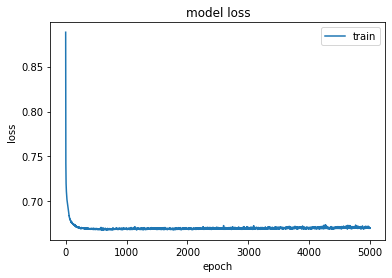

NameError: name 'vae_model' is not defined

In [21]:
opt = RMSprop(learning_rate=0.0001)
opt = Adam(learning_rate=0.00001, clipvalue=0.5)
opt = Adam()


autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss="mse")
autoencoder.summary()

trained = False     # First time train / Next times use saved model to speed up analysis
if trained:
    vae_model = load_model('./Data/vae_model.hf5', custom_objects={'vae_loss': vae_loss})

else:
    results = autoencoder.fit(X_train, X_train,
                        shuffle=True,
                        epochs=5000,
                        batch_size=128)
    # Training figure
    plt.plot(results.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right');
    plt.show()
    # saving weights
    vae_model.save('./Data/vae_model.hf5')

In [22]:
X_train_pred = autoencoder.predict(X_train)

/home/manero/DL/lib/python3.8/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [23]:
mae_vector_train = get_error_term(X_train_pred, X_train, _rmse=False)

print(f'Avg error {np.mean(mae_vector_train)}\nmedian error {np.median(mae_vector_train)}\n99Q:    \
      {np.quantile(mae_vector_train, 0.99)}')
print(f'setting threshold on { np.quantile(mae_vector_train, 0.99)} ')

error_thresh = np.quantile(mae_vector_train, 0.99)
error_thresh = np.quantile(mae_vector_train, 0.995)
error_median = np.quantile(mae_vector_train, 0.5) # Median is 0.5 quantile

print(error_thresh, error_median)

Avg error 0.5093567788346558
median error 0.4317606077220642
99Q:          1.2213742160506227
setting threshold on 1.2213742160506227 
1.3021771367418007 0.4317606077220642


<AxesSubplot:title={'center':'Distribution Plot reconstruction error ignitions'}, ylabel='Count'>

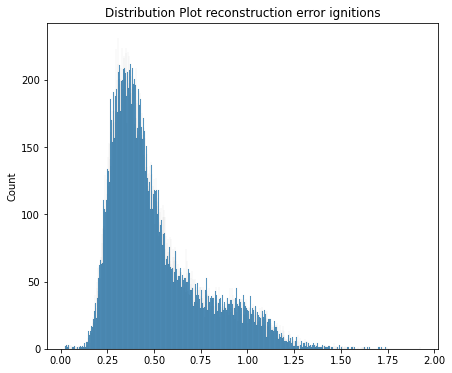

In [24]:
fig, ax = plt.subplots(figsize=(7,6))
ax.set_title('Distribution Plot reconstruction error ignitions')
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
#plt.xlim(0,0.2)
#plt.ylim(0,50)
sns.histplot(data=mae_vector_train, bins = 1000)

In [25]:
X_pred_test = autoencoder.predict(X_test)
print('threshold', error_thresh,error_median)
#train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

mae_vector = get_error_term(X_pred_test, X_test, _rmse=False)
anomalies = (mae_vector > error_median)

np.count_nonzero(anomalies) / len(anomalies)
print('total non_ignitions',len(X_pred_test))
print('number of almost_ignitions', np.count_nonzero(anomalies==0))

#print('total y_test',len(y_test))
#print(np.count_nonzero(y_test))

threshold 1.3021771367418007 0.4317606077220642
total non_ignitions 1000000
number of almost_ignitions 422869


In [26]:
mae_vector

array([0.5725732 , 0.5151554 , 0.50829307, ..., 1.00845582, 0.45929263,
       0.50008945])

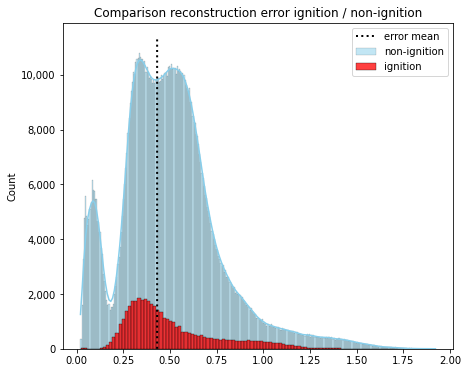

In [27]:
fig,ax1  = plt.subplots(figsize=(7,6))
sns.histplot(data=mae_vector, ax=ax1, color='skyblue', label='non-ignition', kde=True)
sns.histplot(data=mae_vector_train, ax=ax1, color='red', label='ignition')
xmin, xmax, ymin, ymax = plt.axis()
liney = np.arange(ymin, ymax, 0.01)
linex = np.ones(len(liney)) * error_median
sns.lineplot(x = linex, y= liney, color='black', ax=ax1, linewidth=2, estimator = None, 
             linestyle='dotted', label='error mean')
ax1.set_title('Comparison reconstruction error ignition / non-ignition')
ax1.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
#plt.xlim(0,0.2)
#plt.ylim(0,8000)
plt.legend()
plt.show()

In [28]:
error_thresh_low = np.quantile(mae_vector_train, 0.33)
error_thresh_high = np.quantile(mae_vector_train, 0.66)
print(error_thresh_low,error_thresh_high)
near_ignitions = (mae_vector > error_thresh_low )
near_ignitions = ((mae_vector > error_thresh_low) &(mae_vector < error_thresh_high))
near_ignitions = near_ignitions*1 # trick to have near_ignitions as 1 and non-ignitions as 0

0.36071329998540524 0.530115737158926


In [29]:
near_ignitions

array([0, 1, 1, ..., 0, 1, 1])

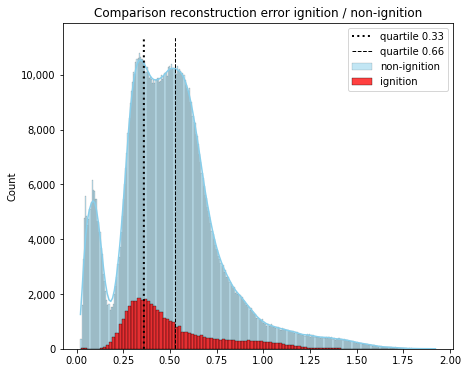

In [30]:
fig,ax1  = plt.subplots(figsize=(7,6))
sns.histplot(data=mae_vector, ax=ax1, color='skyblue', label='non-ignition', kde=True)
sns.histplot(data=mae_vector_train, ax=ax1, color='red', label='ignition')
xmin, xmax, ymin, ymax = plt.axis()
liney = np.arange(ymin, ymax, 0.01)
linex = np.ones(len(liney)) * error_thresh_low
sns.lineplot(x = linex, y= liney, color='black', ax=ax1, linewidth=2, estimator = None, 
             linestyle = 'dotted', label='quartile 0.33')
linex = np.ones(len(liney))* error_thresh_high
sns.lineplot(x = linex, y= liney, color='black', ax=ax1, linewidth=1, estimator = None, 
             linestyle = 'dashed', label='quartile 0.66')
ax1.set_title('Comparison reconstruction error ignition / non-ignition')
ax1.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
#plt.xlim(0,0.2)
#plt.ylim(0,8000)
plt.legend()
plt.show()

In [31]:
# second prediction with X_test vector to be used in PCA transformation
X_pred2 = autoencoder.predict(X_test)
# PCA transformation to observe variance in 2 components

pca = PCA(n_components=3)
X_transform = pca.fit_transform(X_pred2)

/home/manero/DL/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


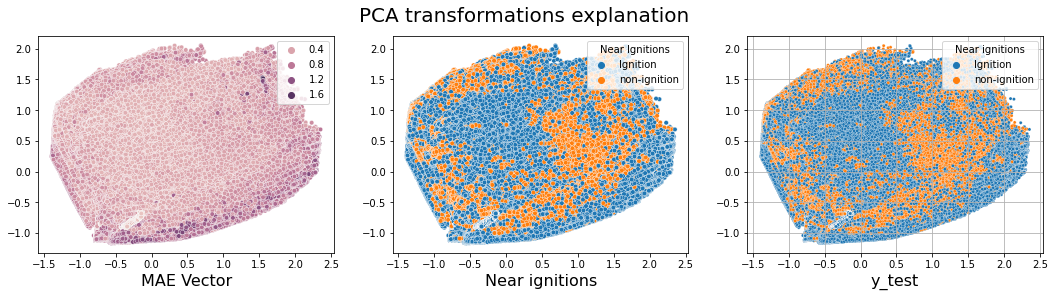

In [32]:
# Figure comparison PCA transformations
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(18,4))
fig.suptitle('PCA transformations explanation',size=20)

sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=20, hue=mae_vector, ax=ax1)
ax1.set_xlabel('MAE Vector', size=16)

sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=20, hue=near_ignitions, ax=ax2)
ax2.set_xlabel('Near ignitions', size = 16)
legend_labels2, _ = ax2.get_legend_handles_labels()
ax2.legend(legend_labels2, ['Ignition', 'non-ignition'], title='Near Ignitions')

sns.scatterplot(x=X_transform[:, 0], y=X_transform[:, 1], s=10, hue=near_ignitions, ax=ax3)
ax3.set_xlabel('y_test', size = 16)
legend_labels3, _ = ax3.get_legend_handles_labels()
ax3.legend(legend_labels3, ['Ignition', 'non-ignition'], title='Near ignitions')

plt.grid()
plt.show()

In [33]:
#===== program ends here. now create a new label and label non-ignition dataset with new class ===== #

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

In [35]:
# Creation of new file 
import time
ignition_df = pd.read_csv(path_ignition)  
non_ignition_df = pd.read_csv(path_non_ignition, nrows=1000000)  
# 2: ignition
# 1: near ignition
# 0: non-ignition
ignition_df['ignition'] = ignition_df['ignition']+1
non_ignition_df['ignition'] = pd.Series(near_ignitions)

fires_df = pd.concat([ignition_df, non_ignition_df])
timestamp = time.strftime("%Y%m%d-%H%M%S")
fires_df.to_csv('./Data/fires_complete_file_'+timestamp+'.csv')  

In [36]:
fires_df['ignition'].value_counts()

0    716615
1    283385
2     51918
Name: ignition, dtype: int64

In [37]:
cols= ['u10', 'v10', 'd2m', 't2m', 'e', 'cvh', 'cvl',
       'skt', 'stl1', 'stl2', 'stl3', 'stl4', 'slt', 'sp', 'tp', 'swvl1',
       'swvl2', 'swvl3', 'swvl4', 'month', 'day', 'hour']
cols_arr = np.array(cols)

In [38]:
tmp = fires_df[cols]
X = tmp
y = fires_df["ignition"].to_numpy()

In [39]:
X_train, X_test, y_train, y_test = train_test_split(tmp, y, test_size=0.25, random_state=42)

In [40]:
#remove Nans and convert them to 0
X_test  = np.nan_to_num(X_test)
X_train = np.nan_to_num(X_train)

In [41]:
rf = RandomForestRegressor(n_estimators=150)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=150)

Text(0.5, 0, 'Feature Importance')

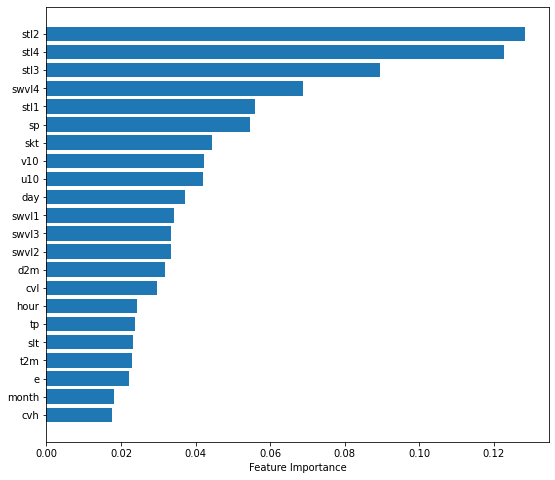

In [42]:
fig,ax  = plt.subplots(figsize=(9,8))
sort = rf.feature_importances_.argsort()
plt.barh(cols_arr[sort], rf.feature_importances_[sort])
plt.xlabel("Feature Importance")

In [43]:
# Predict on test data
y_pred = rf.predict(X_test)
y_train_pred = rf.predict(X_train)

In [44]:
from sklearn.metrics import r2_score

print('score test R2', r2_score(y_test, y_pred))
print('score train R2', r2_score(y_train, y_train_pred))

score test R2 0.8239774301411256
score train R2 0.975415690925747


In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [46]:
from sklearn.metrics import accuracy_score
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.9430717164803407


In [47]:
print(accuracy)

0.9430717164803407


In [48]:
import session_info
session_info.show(html=False)

-----
keras               2.12.0
matplotlib          3.5.0
numpy               1.22.4
pandas              1.5.3
seaborn             0.11.2
session_info        1.0.0
sklearn             1.2.1
tensorflow          2.12.0
-----
IPython             7.29.0
jupyter_client      8.2.0
jupyter_core        5.3.0
notebook            6.5.4
-----
Python 3.8.12 (default, Oct 12 2021, 13:49:34) [GCC 7.5.0]
Linux-5.19.0-45-generic-x86_64-with-glibc2.17
-----
Session information updated at 2023-06-26 21:29


### 